# MNIST Handwritten Character Recognition

## 1. Introduction 

### 1.1 About This Exercise 
This exercise implements the MNIST handwritten character recognition, which is a typical case in the deep learning field. <br>The whole process is as follows: 
    - Process the required dataset. (The MNIST dataset is used in this example.) 
    - Define a network. (A simple fully-connected network is built in this example.) 
    - Define a loss function and an optimizer. 
    - Load the dataset and perform training. 
    - After the training is complete, use the test set for validation.
    
## 2. Preparations 
Before you start, check whether MindSpore has been correctly installed. You are advised to install MindSpore on your computer by referring to the MindSpore official website <br>https://www.mindspore.cn/install/en. <br>In addition, you should have basic mathematical knowledge, including knowledge of Python coding basics, probability, and matrices. 
<br>Recommended environment: 
    - Version: MindSpore 1.7 
    - Programming language: Python 3.7 

## 3. Detailed Design and Implementation 
### 3.1 Data Preparation 
The MNIST dataset used in this example consists of 10 classes of 28 x 28 pixels grayscale images. It has a training set of 60,000 examples, and a test set of 10,000 examples. <br>Download the MNIST dataset at http://yann.lecun.com/exdb/mnist/ (OBS: https://certificationdata.obs.cn-north-4.myhuaweicloud.com/CHS/HCIA-AI/V3.5/chapter4/MNIST.zip). Four dataset download links are provided. The first two links are for downloading test data files, and the last two links are for downloading training data files. <br>Download and decompress the files, and store them in the workspace directories ./MNIST /train and ./MNIST /test. <br>The directory structure is as follows:
<br>
└─MNIST <br>
    ├─ test <br>
        │ t10k-images.idx3-ubyte <br>
        │ t10k-labels.idx1-ubyte <br>
    └─ train <br>
        | train-images.idx3-ubyte <br>
        | train-labels.idx1-ubyte <br>

### 3.2 Procedure 
### Step 1 Import the Python library and module and configure running information. 
Import the required Python library. <br>Currently, the os library is required. Other required libraries will not be described here. For details about the MindSpore modules, see the MindSpore API page. You can use context.set_context to configure the information required for running, such as the running mode, backend information, and hardware information. <br>Import the context module and configure the required information.

In [2]:
# Import related dependent libraries.
import os 
from matplotlib import pyplot as plt 
import numpy as np 

import mindspore as ms 
import mindspore.context as context 
import mindspore.dataset as ds 
import mindspore.dataset.transforms as C 
import mindspore.dataset.vision as CV 
from mindspore.nn.metrics import Accuracy 

from mindspore import nn 
from mindspore.train import Model 
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor 

context.set_context(mode=context.GRAPH_MODE, device_target='CPU')

The graph mode is used in this exercise. <br>You can configure hardware information as required. For example, if the code runs on the Ascend AI processor, set device_target to Ascend. <br>This rule also applies to the code running on the CPU and GPU. For details about parameters, see the context.set_context API description at https://www.mindspore.cn/docs/en/r1.7/api_python/mindspore.context.html.

### Step 2 Read data. 
Use the data reading function of MindSpore to read the MNIST dataset and view the data volume and sample information of the training set and test set.

In [3]:
DATA_DIR_TRAIN = "../datasets/../datasets/MNIST/train" # Training set information 
DATA_DIR_TEST = "../datasets/MNIST/test" # Test set information 

# Read data. 
ds_train = ds.MnistDataset(DATA_DIR_TRAIN) 
ds_test = ds.MnistDataset(DATA_DIR_TEST ) 

# Display the dataset features. 
print('Data volume of the training dataset:',ds_train.get_dataset_size()) 
print('Data volume of the test dataset:',ds_test.get_dataset_size()) 
image=ds_train.create_dict_iterator().__next__() 
print('Image length/width/channels:',image['image'].shape) 
print('Image label style:',image['label']) # Total 10 label classes which are represented by numbers from 0 to 9.

Data volume of the training dataset: 60000
Data volume of the test dataset: 10000
Image length/width/channels: (28, 28, 1)
Image label style: 1


### Step 3 Process data. 
Datasets are crucial for training. A good dataset can effectively improve training accuracy and efficiency. Generally, before loading a dataset, you need to perform some operations on the dataset. Define a dataset and data operations. 
<br>We define the create_dataset function to create a dataset. In this function, we define the data augmentation and processing operations to be performed: 
<ul><li>Read the dataset.</li><li>Define parameters required for data augmentation and processing.</li>  <li>Generate corresponding data augmentation operations according to the parameters.</li> <li>Use the map function to apply data operations to the dataset.</li>  <li>Process the generated dataset.</li> 

In [4]:
def create_dataset(training=True, batch_size=128, resize=(28, 28), rescale=1/255, shift=0, buffer_size=64): 
    ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST) 
    # Define the resizing, normalization, and channel conversion of the map operation. 
    resize_op = CV.Resize(resize) 
    rescale_op = CV.Rescale(rescale,shift) 
    hwc2chw_op = CV.HWC2CHW() 

    # Perform the map operation on the dataset. 
    ds = ds.map(input_columns="image", operations=[rescale_op,resize_op, hwc2chw_op]) 
    ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32)) 

    # Set the shuffle parameter and batch size. 
    ds = ds.shuffle(buffer_size=buffer_size) 
    ds = ds.batch(batch_size, drop_remainder=True) 
    return ds

In the preceding information, batch_size indicates the number of data records in each batch. Assume that each batch contains 32 data records. Modify the image size, normalization, and image channel, and then modify the data type of the label. Perform the shuffle operation, set batch_size, and set drop_remainder to True. In this case, data that cannot form a batch in the dataset will be discarded. MindSpore supports multiple data processing and augmentation operations, which are usually used together. For details, see Data Processing and Augmentation on the MindSpore official website.

## Step 4 Sample visualization 
Read the first 10 samples and visualize the samples to determine whether the samples are real datasets.

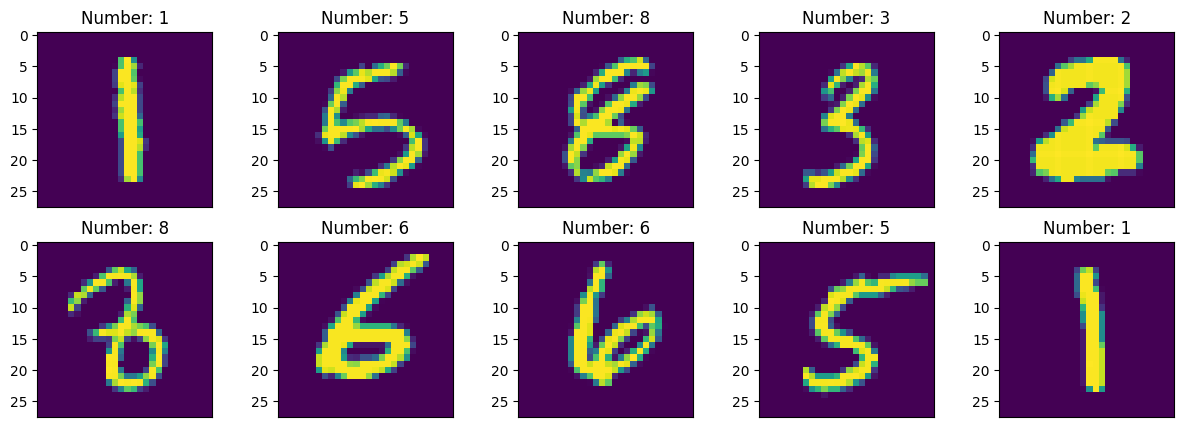

In [5]:
# Display the first 10 images and the labels, and check whether the images are correctly labeled. 
ds = create_dataset(training=False) 
data = ds.create_dict_iterator().__next__() 
images = data['image'].asnumpy() 
labels = data['label'].asnumpy() 

plt.figure(figsize=(15,5)) 
for i in range(1,11): 
    plt.subplot(2, 5, i) 
    plt.imshow(np.squeeze(images[i])) 
    plt.title('Number: %s' % labels[i]) 
    plt.xticks([]) 
plt.show()

### Step 5 Define a network. 
We define a simple fully-connected network to implement image recognition. The network has only three layers: <br>The first layer is a fully-connected layer of the shape 784 x 512. <br>The second layer is a fully-connected layer of the shape 512 x 128. <br>The last layer is an output layer of the shape 128 x 10. <br>To use MindSpore for neural network definition, inherit mindspore.nn.Cell. Cell is the base class of all neural networks (such as Conv2d). <br>Define each layer of a neural network in the \_\_init\_\_ method in advance, and then define the construct method to complete the feedforward construction of the neural network. The network layers are defined as follows:

In [6]:
# Create a model. The model consists of three fully connected layers. The final output layer uses softmax for classification (10 classes consisting of numbers 0 to 9.) 
class ForwardNN(nn.Cell):
    def __init__(self): 
        super(ForwardNN, self).__init__() 
        self.flatten = nn.Flatten() 
        self.fc1 = nn.Dense(784, 512, activation='relu') 
        self.fc2 = nn.Dense(512, 128, activation='relu') 
        self.fc3 = nn.Dense(128, 10, activation=None) 
    def construct(self, input_x): 
        output = self.flatten(input_x) 
        output = self.fc1(output) 
        output = self.fc2(output) 
        output = self.fc3(output) 
        return output

### Step 6 Define a loss function and an optimizer. 
A loss function is also called an objective function and is used to measure the difference between a predicted value and an actual value. <br>Deep learning reduces the loss value by continuous iteration. Defining a good loss function can effectively improve model performance. <br>An optimizer is used to minimize the loss function, improving the model during training. <br>After the loss function is defined, the weight-related gradient of the loss function can be obtained. The gradient is used to indicate the weight optimization direction for the optimizer, improving model performance. Loss functions supported by MindSpore include SoftmaxCrossEntropyWithLogits, L1Loss, and MSELoss. SoftmaxCrossEntropyWithLogits is used in this example. <br>MindSpore provides the callback mechanism to execute custom logic during training. The following uses ModelCheckpoint provided by the framework as an example. ModelCheckpoint can save the network model and parameters for subsequent fine-tuning.

In [7]:
# Create a network, loss function, validation metric, and optimizer, and set related hyperparameters. 

lr = 0.001 
num_epoch = 10 
momentum = 0.9 

net = ForwardNN() 
loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean') 
metrics={"Accuracy": Accuracy()} 
opt = nn.Adam(net.trainable_params(), lr)

### Step 7 Start training. 
The training process refers to a process in which a training dataset is transferred to a network for training and optimizing network parameters. In the MindSpore framework, the Model.train method is used to complete this process.

In [8]:
# Build a model. 
model = Model(net, loss, opt, metrics) 
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10) 
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_net",directory = "./ckpt" ,config=config_ck) 

# Generate a dataset. 
ds_eval = create_dataset(False, batch_size=32)
ds_train = create_dataset(batch_size=32) 

# Train the model. 
loss_cb = LossMonitor(per_print_times=1875) 
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size()) 

print("============== Starting Training ==============") 
model.train(num_epoch, ds_train,callbacks=[ckpoint_cb,loss_cb,time_cb ],dataset_sink_mode=False)

============== Starting Training ==============
epoch: 1 step: 1875, loss is 0.03668900206685066
Train epoch time: 13451.140 ms, per step time: 7.174 ms
epoch: 2 step: 1875, loss is 0.03346202149987221
Train epoch time: 6064.493 ms, per step time: 3.234 ms
epoch: 3 step: 1875, loss is 0.006593471392989159
Train epoch time: 6206.332 ms, per step time: 3.310 ms
epoch: 4 step: 1875, loss is 0.01470639742910862
Train epoch time: 6545.745 ms, per step time: 3.491 ms
epoch: 5 step: 1875, loss is 0.0025012337137013674
Train epoch time: 6326.124 ms, per step time: 3.374 ms
epoch: 6 step: 1875, loss is 0.002670426620170474
Train epoch time: 7413.392 ms, per step time: 3.954 ms
epoch: 7 step: 1875, loss is 5.040990436100401e-05
Train epoch time: 6883.214 ms, per step time: 3.671 ms
epoch: 8 step: 1875, loss is 0.00023788292310200632
Train epoch time: 7324.145 ms, per step time: 3.906 ms
epoch: 9 step: 1875, loss is 0.006807973142713308
Train epoch time: 6672.569 ms, per step time: 3.559 ms
epoch

Although loss values may fluctuate, they gradually decrease and the accuracy gradually increases in general. Loss values displayed each time may be different because of their randomicity.

### Step 8 Validate the model. 
In this step, the original test set is used to validate the model.

In [9]:
# Use the test set to validate the model and print the overall accuracy. 
metrics=model.eval(ds_eval) 
print(metrics)

{'Accuracy': np.float64(0.9784655448717948)}
